<a href="https://colab.research.google.com/github/samvardhan/Bayesian_Regression/blob/main/stan_workshop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pystan

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 36.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 2.8 MB/s eta 0:00:00


In [2]:
# this is needed to enable running stan on collab (there is a bug)
!pip install nest_asyncio

In [20]:
import stan
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
import pandas as pd
import arviz as az
import nest_asyncio
nest_asyncio.apply()

# **LINEAR REGRESSION**!

---
## General Formula
##  Y = alpha + beta * X + e
### Y: data
### X: covariates
### e ~ N(0,sigma)

---





Generate Data

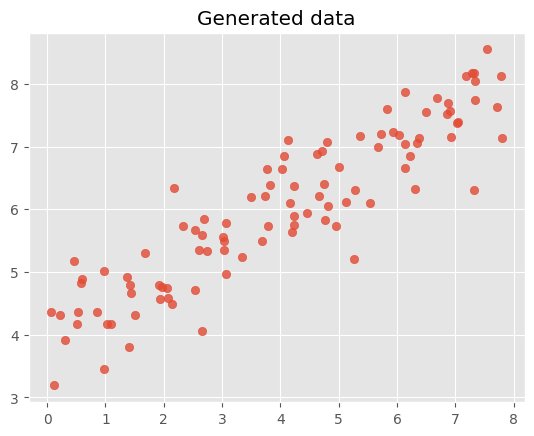

In [70]:
# Parameters to be inferred

alpha = 4.0  #intercept
beta = 0.5 #slopes
sigma = 0.5 #error

# Generate data
x =  8 * np.random.rand(100)

y = alpha + beta * x
y = np.random.normal(y, scale=sigma) #noise

#visualize generated data
plt.scatter(x, y, alpha = 0.8);
plt.title('Generated data');

Build STAN model block

In [71]:
model = """
data {                    //input the data to STAN
    int<lower=0> N;
    vector[N] x;
    vector[N] y;
}

parameters {              //define parameters for the model
    real alpha;
    real beta;
    real<lower=0> sigma;
}

model {                   //define the model structure, and priors

    //priors
    alpha ~ normal(0,10);
    beta ~ normal(0,1);   //why?

    //model
    y ~ normal(alpha + beta * x, sigma);
}

generated quantities {    //get quantities of interest from fitted model
    vector[N] yhat;
    vector[N] log_lik;
    for (n in 1:N){
        yhat[n] = normal_rng(alpha + x[n] * beta, sigma);             //generate samples from model
        log_lik[n] = normal_lpdf( y[n] | alpha + x[n] * beta, sigma); //probability of data given the model and parameters
        }
}
"""

Model Parameters

In [72]:
#STAN takes data as a dict
data = {'N': len(x), 'x': x, 'y': y}

#parameters for STAN fitting
chains = 2
samples = 2000
warmup = 10
# set seed


# Compile the model
posterior = stan.build(model, data=data, random_seed = 42)

# Train the model and generate samples
fit = posterior.sample(num_chains=chains, num_samples=samples)


Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:  50% (3000/6000)
Sampling: 100% (6000/6000)
Sampling: 100% (6000/6000), done.
Messages received during sampling:
  Gradient evaluation took 1.3e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.13 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.2 seconds.
  Adjust your expectations accordingly!


In [73]:
# Extracting traces

alpha = fit['alpha'].reshape(chains,samples) #arviz format
beta = fit['beta'].reshape(chains,samples)
sigma = fit['sigma'].reshape(chains,samples)

lp = fit['lp__'].reshape(chains,samples)


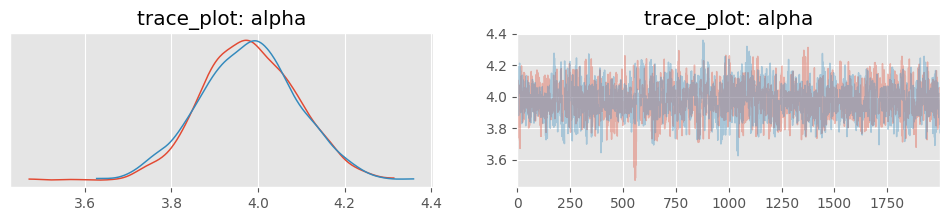

In [74]:
varname = alpha
name = 'alpha'
axes = az.plot_trace(varname, compact=False)
for ax in axes.flatten():
    ax.set_title('trace_plot: {}'.format(name))

<Axes: title={'center': 'x'}>

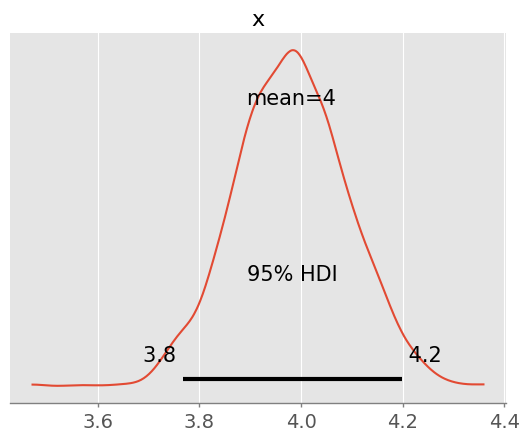

In [75]:
az.plot_posterior(alpha, hdi_prob=0.95)

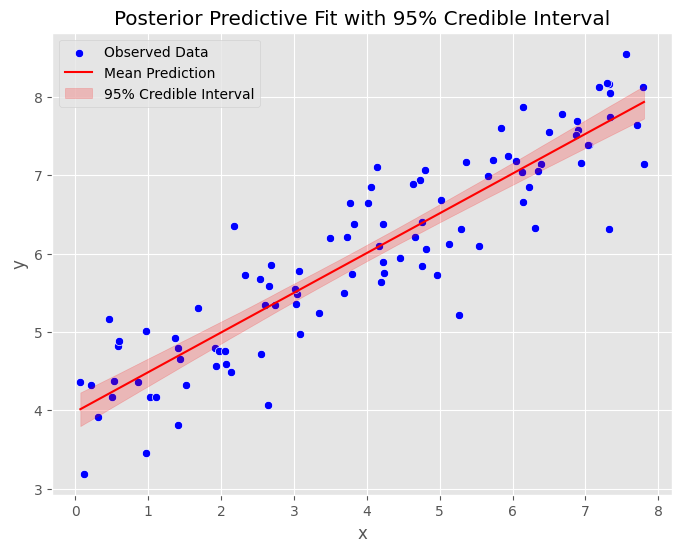

In [76]:
# Convert fit to a DataFrame
fit_df = fit.to_frame()

# Extract parameters from DataFrame
alpha = fit_df['alpha'].values.reshape(chains, samples)
beta = fit_df['beta'].values.reshape(chains, samples)
sigma = fit_df['sigma'].values.reshape(chains, samples)

# Generate x values for prediction
x_pred = np.linspace(min(x), max(x), 100)

# Flatten the parameter samples across chains
alpha_flat = alpha.flatten()
beta_flat = beta.flatten()
sigma_flat = sigma.flatten()

# Compute posterior predictive samples
y_pred_samples = np.array([alpha_flat + beta_flat * xi for xi in x_pred])

# Compute mean and 95% credible interval
y_pred_mean = np.mean(y_pred_samples, axis=1)
y_pred_lower = np.percentile(y_pred_samples, 2.5, axis=1)
y_pred_upper = np.percentile(y_pred_samples, 97.5, axis=1)

# Plot the observed data
plt.figure(figsize=(8, 6))
sns.scatterplot(x=x, y=y, label="Observed Data", color="blue")

# Plot the mean prediction
plt.plot(x_pred, y_pred_mean, color="red", label="Mean Prediction")

# Shade the 95% credible interval
plt.fill_between(x_pred, y_pred_lower, y_pred_upper, color="red", alpha=0.2, label="95% Credible Interval")

# Labels and title
plt.xlabel("x")
plt.ylabel("y")
plt.title("Posterior Predictive Fit with 95% Credible Interval")
plt.legend()
plt.show()


# EXERCISE: Re-Run Linear Regression: 'Try to FAIL'

### 1. Try to make the model convergence fail. To achieve this, you can either-

- Reduce number of iterations *N*
- Use strongly informative but wrong priors for *alpha* or *beta*:
ex. alpha ~ uniform(0,3); beta ~ uniform(1,2);




### 2. *Discuss why convergence failed?*

Hint:
- Did the model have enough samples to converge?
- Did the model get to explore the solution area?






# 2: Group Level Effect

---
## General Formula
##  Y = alpha[group] + beta * X + e
### e ~ N(0,sigma)

Group?
- Students in schools
- Clients nested within therapists within clinics
- Employees nested within organizations
- Citizens nested within employees
- Repeated measures nested within persons
---

Generate Data

In [31]:
# Parameters to be inferred
alpha = [0,6.0,9.0, 7.0]

beta = 0.5

sigma = 1

# Generate and plot data
x1 = 10 * np.random.rand(100)

y1 =  np.random.normal(alpha[1] + beta * x1, scale= sigma)
y2 =  np.random.normal(alpha[2] + beta * x1, scale= sigma)
y3 = np.random.normal(alpha[3] + beta * x1, scale= sigma)

# made up  dataset
df = pd.DataFrame()
df['x'] = np.concatenate((x1, x1, x1))
df['y'] = np.concatenate((y1, y2, y3))
df['group'] = np.concatenate((np.repeat(1, len(y1)),np.repeat(2, len(y2)),np.repeat(3, len(y3))))
df.sample(20)

,x,y,group
41,1.725108,6.170925,1
35,1.746127,5.966996,1
232,1.713689,8.677821,3
131,0.336923,10.145907,2
221,1.671808,8.281170,3
46,9.304791,9.260162,1
36,8.458663,9.490810,1
51,9.346309,8.825695,1
253,9.068002,10.402363,3
89,7.922424,10.227128,1


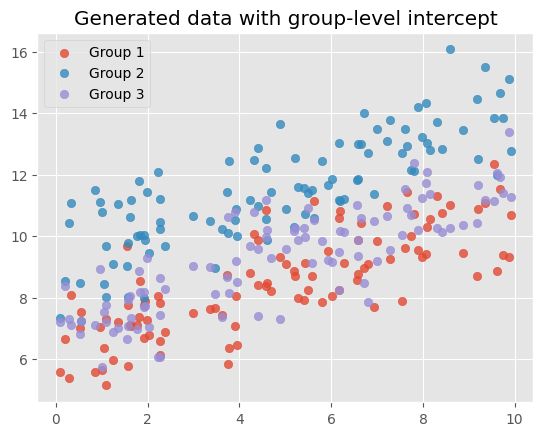

In [29]:
#visualize generated data
plt.scatter(x1, y1, label = 'Group 1', alpha = 0.8)
plt.scatter(x1, y2, label = 'Group 2', alpha = 0.8)
plt.scatter(x1, y3, label = 'Group 3', alpha = 0.8)
plt.legend()
plt.title('Generated data with group-level intercept');

STAN Model Block

In [78]:
group_level_model = """
data {
    int<lower=0> N;
    vector[N] x;
    vector[N] y;

    int<lower=0> J;         //number of groups
    array[N] int group;;    //lookup list for each data point's group ID

}

parameters {
    vector[J] alpha;
    real beta;
    real<lower=0> sigma;
}


transformed parameters { //combining parameters to make intermediate parameters
    vector[N] mu;

    for (n in 1:N){
        mu[n] = alpha[group[n]];
        mu[n] = mu[n] + beta * x[n];
    }

}


model {
    //EXERCISE 2
    beta ~ normal(0,10);

    for (j in 1:J){
      alpha[j] ~ normal(0,10);
      }



    for (n in 1:N){
        y[n] ~ normal(mu[n], sigma);
    }
}

generated quantities{
    vector[N] log_lik;
    vector[N] yhat;
    for (n in 1:N){
        log_lik[n] = normal_lpdf( y[n] | mu[n], sigma);
        yhat[n] = normal_rng( mu[n], sigma);
        }
}

"""

In [83]:
group_level_data = {'N': len(df.x), 'x': df.x.values, 'y': df.y.values,
        'group':df.group.values,'J':df.group.nunique()}
#Note: STAN starts counting at 1

chains = 2
samples = 1000
warmup = 100

# Compile the model
posterior = stan.build(group_level_model, data=group_level_data, random_seed = 42)

# Train the model and generate samples
fit = posterior.sample(num_chains=chains, num_samples=samples)


Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 9.9e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.99 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000108 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.08 seconds.
  Adjust your expectations accordingly!


In [84]:
# Extracting traces
alpha = [fit['alpha'][i].reshape(chains,samples) for i in range(3)]#arviz format
beta = fit['beta'].reshape(chains,samples)
sigma = fit['sigma'].reshape(chains,samples)

lp = fit['lp__'].reshape(chains,samples)

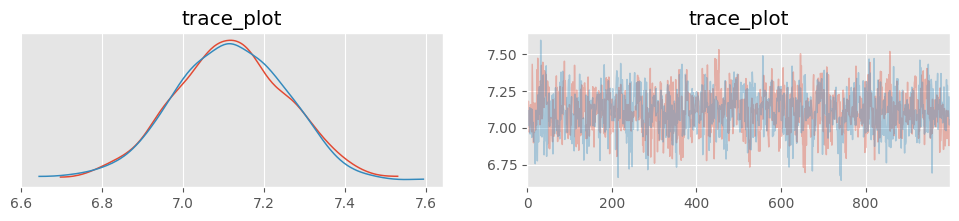

In [85]:
varname = alpha[2]
axes = az.plot_trace(varname, compact=False)
for ax in axes.flatten():
    ax.set_title('trace_plot')

## **Compare Models**
Next, we run the group-level model and the simple model results for the group-level dataset, and compare the results.

Common sense would indicate that the group-level model is a better descriptor of our constructed group-level data. What is a metric that can quantify this?
### Watanabe–Akaike information criterion

https://en.wikipedia.org/wiki/Bayesian_information_criterion


In [87]:
def compute_waic(fit):
    log_lik  = fit['log_lik']
    scale_value=1
    shape         = log_lik.shape
    n_samples     = shape[0]
    n_data_points = shape[1]
    vars_lpd      = np.var(log_lik,axis=0)
    lppd_i        = np.log(np.mean(np.exp(log_lik),axis=0))


    waic_i        = scale_value * (lppd_i - vars_lpd)
    waic_se       = (n_data_points * np.var(waic_i)) ** 0.5
    waic_sum      = np.sum(waic_i)
    p_waic        = np.sum(vars_lpd)
    return [waic_sum,waic_se]



# rewrite simple model

In [88]:
simple_model = """
data {
    int<lower=0> N;
    vector[N] x;
    vector[N] y;
}

parameters {
    real alpha;
    real beta;
    real<lower=0> sigma;
}

model {
    //priors
    alpha ~ normal(0,10);
    beta ~ normal(0,1);

    y ~ normal(alpha + beta * x, sigma);
}

generated quantities {
    vector[N] yhat;
    vector[N] log_lik;
    for (n in 1:N){
        yhat[n] = normal_rng(alpha + x[n] * beta, sigma);
        log_lik[n] = normal_lpdf( y[n] | alpha + x[n] * beta, sigma);
        }
}
"""

# Run both the Simple model and Group level model on group level data

In [89]:
#Group-level Model
posterior_group = stan.build(group_level_model, data=group_level_data, random_seed = 42)
fit_group = posterior_group.sample(num_chains=chains, num_samples=samples )

#Ignoring Group-level effect
posterior = stan.build(simple_model, data=group_level_data,random_seed = 42)
fit = posterior.sample(num_chains=chains, num_samples=samples)

Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 9.9e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.99 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000108 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.08 seconds.
  Adjust your expectations accordingly!


Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling: 100%, done.
Messages received during sampling:
  Gradient evaluation took 3.8e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.38 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.31 seconds.
  Adjust your expectations accordingly!


In [90]:
waic_group = compute_waic(fit_group)
waic = compute_waic(fit)
# Comparative measure
print(waic_group, waic)

[-3557.4929382558685, 2.7623924471800123] [-4258.1208111952665, 1.7306886607320704]


TAKE HOME EXERCISE


---


Similar to intercept alpha, add Group-Level Effect for slope Beta.

In [92]:
# END :)